### NCO Algorithm

Machine Learning for Asset Manager, Chapter 7 "portfolio construction"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from FinancialMachineLearning.filter.denoising import *
from FinancialMachineLearning.portfolio_optimization.clustering import *

import warnings
warnings.filterwarnings('ignore')

상관계수가 0이 아닐 때 포트폴리오 최적화 조건의 수

In [2]:
corr0 = GenerateSamples.formBlockMatrix(2, 2, 0.5)
eVal, eVec = np.linalg.eigh(corr0)
print(max(eVal) / min(eVal))

3.0


블록 내 상관관계는 0.5이고, 외부 블록 상관관계는 0이다. 이러한 구조 때문에 조건의 수는 1이 아닌 3으로 계산된다

<Axes: >

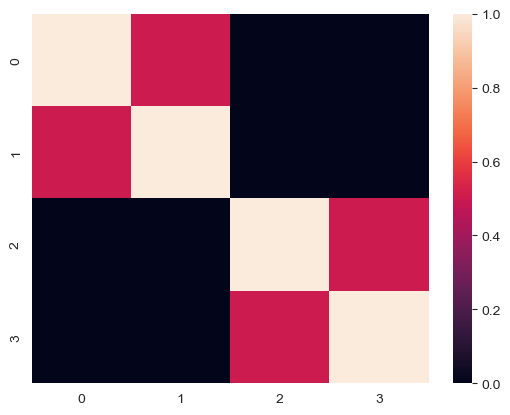

In [3]:
sns.heatmap(corr0)

지배적인 군집을 별도로 최적화해도 조건의 수는 달라지지 않는다. Markowitz의 해의 불안정성은 상관행렬 내 소수의 지배적인 군집에서 기인할 수 있다. 별도로 최적화를 하면 불안정성을 억제할 수 있고, 따라서 불안정성이 포트폴리오 전체로 확산되는 것을 방지할 수 있다

In [4]:
corr0 = block_diag(GenerateSamples.formBlockMatrix(1, 2, 0.5))
corr1 = GenerateSamples.formBlockMatrix(1, 2, 0)
corr0 = block_diag(corr0, corr1)

eVal, eVec = np.linalg.eigh(corr0)
print(max(eVal) / min(eVal))

3.0


#### Nested Clustered Optimization

In [6]:
nBlocks, bSize, bCorr, q  = 2, 2, .5, 10
np.random.seed(42)
mu0, cov0 = GenerateSamples.formTrueMatrix(nBlocks, bSize, bCorr)

In [7]:
cols = cov0.columns

In [8]:
cov1 = GenerateSamples.denoise_covariance(cov0, q, bWidth = 0.01)
cov1 = pd.DataFrame(cov1, index = cols, columns = cols)
corr1 = covariance_to_correlation(cov1)
corr1, clusters, silh = clusterKMeansBase(corr1, maxNumClusters = int(corr0.shape[0]/2), n_init = 10)

In [9]:
wIntra = pd.DataFrame(0, index = cov1.index, columns = clusters.keys())
for i in clusters : wIntra.loc[clusters[i], i] = optimizing_portfolio(cov1.loc[clusters[i], clusters[i]]).flatten()
cov2 = wIntra.T.dot(np.dot(cov1, wIntra))

cov2는 축약된 공분산 행렬을 나타낸다

In [10]:
cov2

,0,1
0,0.005376,0.000000
1,0.000000,0.005383


Markowitz의 저주에서 벗어나 $\rho \sim 0$인 상태에서의 문제로 변환 가능하다. 아래 코드를 통해 최적 배분을 시행한다

In [11]:
winter = pd.Series(optimizing_portfolio(cov2).flatten(), index = cov2.index)
wAII0 = wIntra.mul(winter, axis = 1).sum(axis = 1).sort_index()

**실험 결과**

In [13]:
nBlocks, bSize, bCorr = 10, 50, 0.5
np.random.seed(42)
mu0, cov0 = GenerateSamples.formTrueMatrix(nBlocks, bSize, bCorr)

In [14]:
nObs, nSims, shrink, minVarPortf = 100, 10, False, True
w1 = pd.Series([])
w1_d = pd.Series([])
for i in range(nSims) :
    mu1, cov1 = GenerateSamples.simCovMu(mu0, cov0, nObs, shrink = shrink)
    if minVarPortf : mu1 = None
    w1.loc[i] = optimizing_portfolio(cov1, mu1).flatten()
    w1_d.loc[i] = nested_clustered_optimization(cov1, mu1, int(cov1.shape[0]/2)).flatten()

In [15]:
temp1 = pd.DataFrame()
for i in range(10) :
    temp1[i] = w1[i]

In [17]:
w1 = temp1.values.T

In [18]:
temp2 = pd.DataFrame()
for i in range(10) :
    temp2[i] = w1_d[i]

In [19]:
w1_d = temp2.values.T

In [20]:
w0 = optimizing_portfolio(cov0, None if minVarPortf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis = 0)
rmsd = np.mean(pd.DataFrame(w1 - w0).values.flatten() ** 2) ** 0.5
rmsd_d = np.mean(pd.DataFrame(w1_d - w0).values.flatten() ** 2) ** 0.5

In [39]:
rmse = np.mean(pd.DataFrame(w0).values.flatten() ** 2) ** 0.5
rmse1 = np.mean(pd.DataFrame(w1).values.flatten() ** 2) ** 0.5

print(f'RMSE : {rmse}')
print(f'RMSE : {rmse1}')

RMSE : 0.007048263584716212
RMSE : 0.28435956447326455


In [34]:
print(f'RMSE : {rmsd}')
print(f'RMSE : {rmsd_d}')

RMSE : 0.2843798384568882
RMSE : 0.005670717379949412


#### Maximum Sharpe Ratio Portfolio

In [24]:
nObs, nSims, shrink, minVarPortf = 100, 10, True, True
w2 = pd.Series()
w2_d = pd.Series()
for i in range(nSims) :
    mu2, cov2 = GenerateSamples.simCovMu(mu0, cov0, nObs, shrink = shrink)
    if minVarPortf : mu2 = None
    w2.loc[i] = optimizing_portfolio(cov2, mu2).flatten()
    w2_d.loc[i] = nested_clustered_optimization(cov2, mu2, int(cov2.shape[0]/2)).flatten()

In [25]:
temp1 = pd.DataFrame()
for i in range(10) :
    temp1[i] = w2[i]

In [26]:
w2 = temp1.values.T

In [27]:
temp2 = pd.DataFrame()
for i in range(10) :
    temp2[i] = w2_d[i]
w2_d = temp2.values.T

In [36]:
rmse2 = np.mean(pd.DataFrame(w0).values.flatten() ** 2) ** 0.5

print(f'RMSE : {rmse2}')

RMSE : 0.007048263584716212


In [28]:
rmsd2 = np.mean(pd.DataFrame(w2 - w0).values.flatten() ** 2) ** 0.5
rmsd_d2 = np.mean(pd.DataFrame(w2_d - w0).values.flatten() ** 2) ** 0.5

In [33]:
print(f'RMSE : {rmsd2}')
print(f'RMSE : {rmsd_d2}')

RMSE : 0.0055076240066797314
RMSE : 0.00357341934959203
